## Octave code to implement a bar-delta filter
This Jupyiter notebook contains sample code to demonstrate the operation of the bar-delta filter. First, you will create a synthetic dataset (the idea of desktop validation) for a four-cell battery pack. Then, you will use this synthetic dataset as input to a bar-delta filter to estimate the SOCs of all cells efficiently.

In [1]:
% Add the ESC toolbox functions to the path
addpath readonly

The following code segment creates a synthetic dataset for a four-cell battery pack where every cell has a different initial SOC, different series resistance R0, and different total capacity. The input current is a sequence of two UDDS profiles separated by rest intervals.

This code segment needs to be executed only once. It will write its output to "PANPackData.mat", which is read as input to the bar-delta filter.

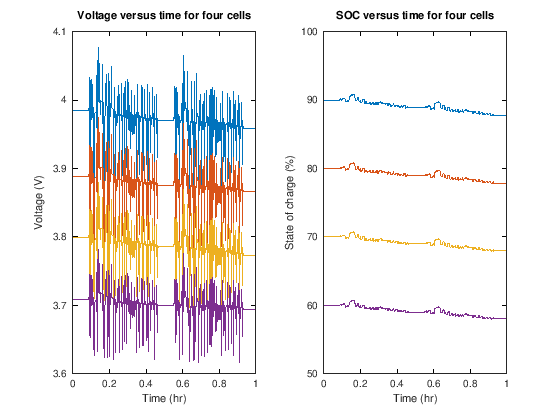

In [2]:
% Use a desktop-validation approach to create a synthetic dataset
% This dataset assumes a 4-cell battery pack comprising Panasonic 25 Ah
% cells. The cells have different series resistances, different capacities,
% and different initial states of charge. They are all exercised with the
% same profile of current versus time, which comprises two UDDS profiles
% separated by rest intervals.

load readonly/PANmodel;           % ESC model of Panasonic cell
udds = load('readonly/udds.txt'); % profile of current versus time for UDDS
T = 25;

z0 = 0.9:-0.1:0.6;       % set initial SOC for each cell in pack
R0 = (1.3:-0.1:1)*1e-3;  % set R0 for each cell in pack
Q0 = 25:28;              % set Q for each cell in pack
% create current profile: rest/udds/rest/udds/rest
ik = [zeros(300,1); udds(:,2); zeros(300,1); udds(:,2); zeros(241,1)];

vk = zeros(length(ik),length(z0)); % reserve storage for cell voltages
zk = zeros(length(ik),length(z0)); % reserve storage for cell SOCs

for k = 1:length(z0),
  model.R0Param = R0(k)*ones(size(model.R0Param)); % overwrite R0
  model.QParam  = Q0(k)*ones(size(model.QParam)); % overwrite Q
  [vcell,rck,hk,zcell,sik,OCV] = simCell(ik,T,1,model,z0(k),0,0);
  vk(:,k) = vcell;
  zk(:,k) = zcell;
end
save('PANPackData.mat','vk','zk','ik','T','Q0','R0');

subplot(1,2,1); t = (0:length(ik)-1)/3600;
plot(t,vk); xlabel('Time (hr)'); ylabel('Voltage (V)');
title('Voltage versus time for four cells');

subplot(1,2,2);
plot(t,100*zk); xlabel('Time (hr)'); ylabel('State of charge (%)');
title('SOC versus time for four cells');

The following code segment is the initSPKF "helper function", modified from what you have seen earlier to support estimating the current-sensor bias and to support a bar-delta approach to estimating all cell SOCs. Notice the new state for current-sensor bias having index spkfData.biasInd. Also notice the additional statements at the end of the function to initialize the constants of the delta filters for SOC estimation.

In [3]:
% init SPKF for bar-delta method
function spkfData = initSPKF(v0, T0, SigmaX0, SigmaV, SigmaW, model)
  % First, initialize the variables for the "bar" filter
  % Initial state description
  ir0 = 0; spkfData.irInd = 1;
  hk0 = 0; spkfData.hkInd = 2;
  SOC0 = mean(SOCfromOCVtemp(v0, T0, model)); spkfData.zkInd = 3;
  ib0 = 0; spkfData.biasInd = 4; % Add state to estimate current sensor bias
  spkfData.xhat = [ ir0 hk0 SOC0 ib0]'; % initial state

  % Covariance values
  spkfData.SigmaX = SigmaX0;
  spkfData.SigmaV = SigmaV;
  spkfData.SigmaW = SigmaW;
  spkfData.Snoise = real(chol(blkdiag(SigmaW, SigmaV), 'lower' ));
  spkfData.Qbump = 5;

  % SPKF specific parameters
  Nx = length(spkfData.xhat); spkfData.Nx = Nx; % state-vector length
  Ny = 1; spkfData.Ny = Ny; % measurement-vector length
  Nu = 1; spkfData.Nu = Nu; % input-vector length
  Nw = size(SigmaW,1); spkfData.Nw = Nw; % process-noise-vector length
  Nv = size(SigmaV,1); spkfData.Nv = Nv; % sensor-noise-vector length
  Na = Nx+Nw+Nv; spkfData.Na = Na; % augmented-state-vector length

  h = sqrt(3); spkfData.h = h; % SPKF/CDKF tuning factor
  Weight1 = (h*h-Na)/(h*h); % weighting factors when computing mean
  Weight2 = 1/(2*h*h); % and covariance
  spkfData.Wm = [ Weight1; Weight2*ones(2*Na,1)]; % mean
  spkfData.Wc = spkfData.Wm; % covar

  % previous value of current
  spkfData.priorI = 0;
  spkfData.signIk = 0;

  % store model data structure too
  spkfData.model = model;
  
  % Now, initialize variables for the "delta" filters
  % SOC is estimated using SPKF
  dNx = 1; spkfData.dNx = dNx; % one state per delta filter, for estimating SOC
  dNw = 1; spkfData.dNw = dNw; % one process-noise per delta filter
  dNa = dNx+dNw; spkfData.dNa = dNa; % augmented length for delta filters
  
  spkfData.dh = h; 
  Weight1 = (h*h-dNa)/(h*h); % weighting factors when computing mean
  Weight2 = 1/(2*h*h); % and covariance
  spkfData.dWm = [ Weight1; Weight2*ones(2*dNa,1)]; % mean
  spkfData.dWc = spkfData.dWm; % covar
  
  spkfData.celldz = 0*v0(:);
  spkfData.cellSdz = SigmaX0(spkfData.zkInd,spkfData.zkInd)*ones(size(v0(:)));  
end

The following code is the iterSPKF "helper function" for the bar-delta approach. The largest difference between this code and the earlier version is the "for" loop toward the end that implements the delta filters. Also note the cellStateEqn and cellOutputEqn functions, used by the delta-filter SPKFs.

In [4]:
function [zkbar, zkbarbnd, dzk, dzkbnd, ib, ibbnd, spkfData] = ...
         iterSPKF(vk, ik, Tk, deltat, spkfData)
  model = spkfData. model;

  % Load the cell model parameters
  G = getParamESC('GParam' , Tk, model);
  M = getParamESC('MParam' , Tk, model);
  RC = exp(-deltat./abs(getParamESC('RCParam' , Tk, model)))';
  R = getParamESC('RParam' , Tk, model)';
  R0 = getParamESC('R0Param' , Tk, model);

  % Get data stored in spkfData structure
  I = spkfData.priorI;
  SigmaX = spkfData.SigmaX;
  xhat = spkfData.xhat;
  celldz = spkfData.celldz;
  cellSdz = spkfData.cellSdz;
  Nx = spkfData.Nx;
  Nw = spkfData.Nw;
  Nv = spkfData.Nv;
  Na = spkfData.Na;
  Snoise = spkfData.Snoise;
  Wc = spkfData.Wc;
  irInd = spkfData.irInd;
  hkInd = spkfData.hkInd;
  zkInd = spkfData.zkInd;
  ibInd = spkfData.biasInd; % Add index for current-sensor bias estimator
  
  dQinv = spkfData.dQinv;
  Qinvbar = spkfData.Qinvbar;

  % Step 1a : State estimate time update
  %       - Create xhatminus augmented SigmaX points
  %       - Extract xhatminus state SigmaX points
  %       - Compute weighted average xhatminus(k)

  % Step 1a-1: Create augmented SigmaX and xhat
  [ sigmaXa, p] = chol(SigmaX, 'lower' );
  if p>0,
    fprintf('Cholesky error. Recovering...\n' );
    theAbsDiag = abs(diag(SigmaX));
    sigmaXa = diag(max(SQRT(theAbsDiag), SQRT(spkfData.SigmaW(1,1))));
  end
  sigmaXa=[real(sigmaXa) zeros([Nx Nw+Nv]); zeros([Nw+Nv Nx]) Snoise];
  xhata = [ xhat; zeros([Nw+Nv 1])];
  % NOTE: sigmaX a is lower-triangular

  % Step 1a-2: Calculate SigmaX points (strange indexing of xhat a to
  % avoid "repmat" call, which is very inefficient in MATLAB)
  Xa = xhata(:, ones([1 2*Na+1])) + ...
      spkfData.h*[zeros([ Na 1]), sigmaXa, -sigmaXa];

  % Step 1a-3: Time update from last iteration until now
  %   state Eqn(xold, current, xnoise)
  Xx = stateEqn(Xa(1: Nx,:), I, Xa(Nx+1: Nx+Nw,:));
  xhat = Xx*spkfData.Wm;

  % Step 1b: Error covariance time update
  %           - Compute weighted covariance sigmaminus(k)
  %           (strange indexing of xhat to avoid "repmat" call)
  Xs = Xx - xhat(:,ones([1 2*Na+1]));
  SigmaX = Xs*diag(Wc)*Xs';

  % Step 1c: Output estimate
  %           - Compute weighted output estimate yhat(k)
  I = ik; yk = vk;
  Y = outputEqn(Xx, I, Xa(Nx+Nw+1: end,:), Tk, model);
  yhat = Y*spkfData.Wm;

  % Step 2a: Estimator gain matrix
  Ys = Y - yhat(:, ones([1 2*Na+1]));
  SigmaXY = Xs*diag(Wc)*Ys';
  SigmaY = Ys*diag(Wc)*Ys';
  L = SigmaXY/SigmaY;

  % Step 2b: State estimate measurement update
  r = mean(yk) - yhat; % residual. Use to check for sensor errors...
  if r^2 > 100*SigmaY, L(:,1)=0.0; end
  xhat = xhat + L*r;
  xhat(zkInd)=min(1.05, max(-0.05, xhat(zkInd)));

  % Step 2c: Error covariance measurement update
  SigmaX = SigmaX - L*SigmaY*L';
  [~, S, V] = svd(SigmaX);
  HH = V*S*V';
  SigmaX = (SigmaX + SigmaX' + HH + HH')/4; % Help maintain robustness

  % Q-bump code
  if r^2>4*SigmaY, % bad voltage estimate by 2-SigmaX, bump Q
      fprintf('Bumping sigmax\n' );
      SigmaX(zkInd, zkInd) = SigmaX(zkInd, zkInd)*spkfData.Qbump;
  end

  % Save data in spkfData structure for next time...
  ib = xhat(ibInd);
  ibbnd = 3*sqrt(SigmaX(ibInd, ibInd));
  spkfData.priorI = ik;
  spkfData.SigmaX = SigmaX;
  spkfData.xhat = xhat;
  zkbar = xhat(zkInd);
  zkbarbnd = 3*sqrt(SigmaX(zkInd, zkInd));
  
  % The "bar" filter update is complete. Now, work on "delta" filter updates
  offset = M*xhat(hkInd) - R*xhat(irInd) - R0*(ik-ib);
  for thecell = 1:length(vk),
    % Implement SPKF for delta-soc
    I = spkfData.priorI;
    % First, update the delta-SOC SPKFs
    % Step 1a - State prediction time update
    cellxa = [celldz(thecell); 0];
    cellSxa = diag([SQRT(cellSdz(thecell)), sqrt(spkfData.SigmaW(1,1))]);
    cellXa = cellxa(:,ones([1 2*spkfData.dNa+1])) + ...
             spkfData.h*[0*cellxa,cellSxa,-cellSxa];
    cellXx = cellStateEqn(cellXa,I-ib,dQinv(thecell));
    celldz(thecell) = cellXx*spkfData.dWm;
    % Step 1b - Do error covariance time update
    cellXs = cellXx - celldz(thecell);
    cellSdz(thecell) = cellXs*diag(spkfData.dWc)*cellXs';
    % Step 1c - output estimate
    I = ik;     
    cellY = cellOutputEqn(cellXx,I-ib,cellXa,zkbar,spkfData.dR0(thecell),offset,Tk,model);
    cellyhat = cellY*spkfData.dWm;
    % Step 2a - Estimator gain matrix
    cellYs = cellY - cellyhat;
    cellSy = cellYs*diag(spkfData.dWc)*cellYs' + spkfData.SigmaV; % lin sensor noise
    cellSxy = cellXs*diag(spkfData.dWc)*cellYs';
    cellL = cellSxy/cellSy;
    % Step 2b - State estimate measurement update
    celldz(thecell) = celldz(thecell) + cellL*(vk(thecell) - cellyhat);
    % Step 2c - Error covariance measurement update
    cellSdz(thecell) = cellSdz(thecell) - cellL*cellSy*cellL;
  end

  % Save data in spkfData structure for next time...
  spkfData.celldz = celldz;
  spkfData.cellSdz = cellSdz;
  dzk = celldz;
  dzkbnd = 3*sqrt(cellSdz);

  % Calculate new states for all of the old state vectors in xold.
  function xnew = stateEqn(xold, current, xnoise)
    current = current + xnoise(1,:); % noise adds to current
    xnew = 0*xold;
    xnew(irInd,:) = RC*xold(irInd,:) + (1-RC)*(current-xold(ibInd,:));
    Ah = exp(-abs((current+xold(ibInd,:))*G*deltat*Qinvbar/3600)); % hysteresis factor
    xnew(hkInd,:) = Ah.*xold(hkInd,:) + (Ah-1).*sign(current-xold(ibInd,:));
    xnew(zkInd,:) = xold(zkInd,:) - (current-xold(ibInd,:))*Qinvbar/3600;
    xnew(hkInd,:) = min(1, max(-1, xnew(hkInd,:)));
    xnew(zkInd,:) = min(1.05, max(-0.05, xnew(zkInd,:)));
    xnew(ibInd,:) = xold(ibInd,:) + xnoise(2,:);
  end

  function xnew = cellStateEqn(xold,oldI,celldQinv)
    xnew = xold(1,:) - (oldI + xold(2,:))*celldQinv/3600; % use "known" inverse capacities
  end

  % Calculate cell output voltage for all of state vectors in xhat
  function yhat = outputEqn(xhat, current, ynoise, T, model)
    yhat = OCVfromSOCtemp(xhat(zkInd,:), T, model);
    yhat = yhat + M*xhat(hkInd,:); 
    yhat = yhat - R*xhat(irInd,:) - R0*(current - xhat(ibInd,:)) + ynoise(1,:);
  end

  function yhat = cellOutputEqn(cellXx,I,cellXa,Z,dR,offset,T,model)
    I = I + cellXa(2,:); % add current noise to current
    yhat = OCVfromSOCtemp(Z+cellXx,T,model); % OCV part
    yhat = yhat - I * dR; % delta resistance part
    yhat = yhat + offset; % polarization, hysteresis, bar resistance
    % note: sensor noise handled separately
  end
  
  % "Safe" square root
  function X = SQRT(x)
      X = sqrt(max(0, x));
  end
end

The following is the "wrapper code" to implement the bar-delta filter on the dataset that you created at the beginning of this notebook. Notice where the current-sensor bias is defined at the beginning of this function (you will need to change this to complete your quiz problems). 

The code segment also plots some results. First, it plots the true pack-average SOC and overlays the bar-filter SOC estimate (with error bounds) for easy comparison. It also plots the individual cell SOCs to show that they are quite different from the average value, and yet the bar filter does a great job predicting the pack-average SOC.

Second, it plots the true current-sensor bias and overlays the bar-filter current-sensor-bias estimate (with error bounds). Over the execution of these two UDDS profiles, the bar filter is able to converge quite closely to the true value of current-sensor bias.

Finally, it plots the true individual cell SOCs as well as the bar-delta estimate of all SOCs (with error bounds). Once again, the bar-delta approach does very well.

Note: For simplicity of presentation, this code does not estimate cell total (inverse) capacity or resistance. By now, you should have enough background to implement these yourself!

Starting SPKF
  Completed 250 out of 3601 iterations
  Completed 500 out of 3601 iterations
  Completed 750 out of 3601 iterations
  Completed 1000 out of 3601 iterations
  Completed 1250 out of 3601 iterations
  Completed 1500 out of 3601 iterations
  Completed 1750 out of 3601 iterations
  Completed 2000 out of 3601 iterations
  Completed 2250 out of 3601 iterations
  Completed 2500 out of 3601 iterations
  Completed 2750 out of 3601 iterations
  Completed 3000 out of 3601 iterations
  Completed 3250 out of 3601 iterations
  Completed 3500 out of 3601 iterations


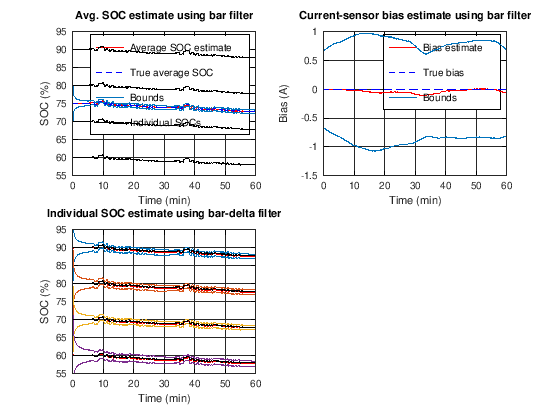

In [5]:
clear
% Can set an artificial current-sensor bias to see how well the SPKF
% estimates this bias
ibias = 0; % can set this (e.g., to 0 or 0.5 A)

% Load cell-test data . Contains variable "DYNData" of which the field
% "script1" is of interest. It has sub-fields time, current, voltage, soc.
load readonly/PANmodel.mat; % loads cell model
load PANPackData.mat;
time = 0:length(ik)-1; time = time(:); deltat = 1;
current = ik + ibias;
voltage = vk;
soc = zk;

% For this somewhat simplified example, we will not estimate 
% capacity inverse. Instead, we assume perfect knowledge of capacity
% of every cell, and hence capacity inverse of every cell
Qinv = 1./Q0; Qinvbar = mean(Qinv); dQinv = Qinv - Qinvbar;
% Similarly, we will not estimate the delta-R0 values, but assume knowledge
dR0 = getParamESC('R0Param',T,model) - R0;

% Reserve storage for computed results, for plotting
sochat = 0*time;    % reserve storage for bar-soc values
socbound = sochat;  % and bounds on those values
bias = sochat;      % ... also for current-sensor bias estimate
biasBound = sochat; % and bounds on that estimate

dsochat = zeros(size(voltage));   % reserve storage for delta-soc values
dsocbound = zeros(size(voltage)); % and for bounds on those values
dR = zeros(size(voltage));        % reserve storage for delta-R0 values
dRbound = zeros(size(voltage));   % and for bounds on those values

% Covariance values
% State ordering: ir,h,z,bias
SigmaX0 = diag([1e2 1e-4 1e-2 5e-2]); % uncertainty of initial state
SigmaV = 1e-3; % uncertainty of voltage sensor, output equation
SigmaW = diag([1e-1, 1e-4]); % uncertainty of current sensor, bias

spkfData = initSPKF(voltage(1,:), T, SigmaX0, SigmaV, SigmaW, model);
spkfData.Qinvbar = Qinvbar; spkfData.dQinv = dQinv; spkfData.dR0 = dR0;

% Now, enter loop for remainder of time, where we update the SPKF
% once per sample interval
fprintf('Starting SPKF\n');
for k = 1:size(voltage,1),
  vk = voltage(k,:); % "measure" voltage
  ik = current(k); % "measure" current
  Tk = T; % "measure" temperature

  % Update SOC (and other model states) of bar filter
  [sochat(k), socbound(k), dsochat(k,:), dsocbound(k,:), bias(k), biasBound(k), spkfData] = ...
      iterSPKF(vk, ik, Tk, deltat, spkfData);

  % update waitbar periodically, but not too often (slow procedure)
  if mod(k,250)==0, fprintf('  Completed %d out of %d iterations\n',k,size(voltage,1)); end
end

% Display output
subplot(2,2,1); 
plot(time/60,100*sochat, '-r',  time/60, 100*mean(soc,2), '--b'); hold on
h = plot([time/60; NaN; time/60],...
        [100*(sochat+socbound); NaN; 100*(sochat-socbound)]);
plot(time/60,100*soc, '-k');
ylim([55 95]);
title('Avg. SOC estimate using bar filter' );
xlabel('Time (min)' ); ylabel('SOC (%)');
legend('Average SOC estimate', 'True average SOC', 'Bounds', 'Individual SOCs'); grid on

subplot(2,2,2);
plot(time/60,bias, '-r',  time/60, ibias*ones(size(bias)), '--b'); hold on
h = plot([time/60; NaN; time/60],...
        [bias+biasBound; NaN; bias-biasBound]);
title('Current-sensor bias estimate using bar filter' );
xlabel('Time (min)' ); ylabel('Bias (A)' );
legend('Bias estimate', 'True bias', 'Bounds'); grid on

subplot(2,2,3);
sochat = repmat(sochat,1,4);
socbound = repmat(socbound,1,4);
plot(time/60,100*(sochat+dsochat), '-r'); hold on
h = plot([time/60; NaN; time/60],...
        [100*(sochat+dsochat+socbound+dsocbound); NaN(1,4); 100*(sochat+dsochat-dsocbound-socbound)]);
plot(time/60,100*soc, '-k');
ylim([55 95]);
title('Individual SOC estimate using bar-delta filter' );
xlabel('Time (min)' ); ylabel('SOC (%)'); grid on

In [6]:
% How to compute rms soc-estimation error for the bar filter (in percent)
100*sqrt(mean((mean(soc,2)-sochat(:,1)).^2))

ans =  0.080220


In [7]:
% How to compute rms soc-estimation errors for the four bar-delta filters (in percent)
sqrt(mean(100*(soc-sochat).^2))

ans =

   1.50008   0.50377   0.49291   1.48973



In [8]:
% How to compute the rms current-sensor bias estimation error over the final minute of the simulation (in mA)
1000*sqrt(mean((ibias - bias(end-59:end)).^2))

ans =  58.653
